### IronHack DA Bootcamp - Jul24 Lisbon
### Final Project - ML Creditworthiness Train Prediction

Credit scoring models allow lenders to evaluate the creditworthiness of individuals and organizations and ensure that their exposure to liability is manageable. 

This allows lenders to assess the level of risk in their loan portfolio.

The aim of this code is to mimic the intelligent system that segregates clients into “credit score”, based on their bank details and credit-related information and predict if it's safe or unsafe to lend money to the prospector, despite of it's credit score .

This feature intends to reduce the manual efforts of analysis and accelerate the credit feedback to clients.


In [139]:
#import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re #Regex

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [141]:
bank_df = pd.read_csv("cscore_train.csv", low_memory=False)

print('Dataset initial configuration')

print(f'\nDimension (Rows, Columns):{bank_df.shape}')

num_dist_cli = bank_df['Customer_ID'].nunique()
print(f'\nNumber of distinct clients: {num_dist_cli}')

months = bank_df['Month'].values
print(f'\nMonths of Analysis: {months}')


Dataset initial configuration

Dimension (Rows, Columns):(100000, 28)

Number of distinct clients: 12500

Months of Analysis: ['January' 'February' 'March' ... 'June' 'July' 'August']


### EDA ###

In [142]:
#'Month'
#replaced the month label for numeric values for better performance
replace_month_dict = {'January':1,
                      'February':2,
                      'March':3,
                      'April':4,
                      'May':5,
                      'June':6,
                      'July':7,
                      'August':8
                    }
bank_df['Month'] = bank_df['Month'].replace(replace_month_dict)




#'Name'
#mapping unique name vs customer_id
unique_cust_name_df = bank_df.dropna(subset=['Name']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Name']

#filling NAN cells with the name of customer mapped with customer_id
bank_df['Name'] = bank_df['Name'].fillna(bank_df['Customer_ID'].map(unique_cust_name_df))



#'Age'
#Removing the non-numerical caracthers and converting column 'Age' from type object to integer
bank_df['Age'] = bank_df['Age'].str.replace(r'\D','', regex=True)
bank_df['Age'] = bank_df['Age'].astype(int)




#'Annual_Income'
#Removing the non-numerical caracthers and converting column 'Annual_Income' from type object to float
bank_df['Annual_Income'] = bank_df['Annual_Income'].str.replace('_','')
bank_df['Annual_Income'] = bank_df['Annual_Income'].astype(float)

#mapping and replacing the corresponding age values for customer_id
cust_age_map = bank_df.dropna(subset=['Age']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Age']
cust_age_map = bank_df.groupby('Customer_ID')['Age'].median()
bank_df['Age'] = bank_df['Customer_ID'].map(cust_age_map)




#'SSN', 'Occupation', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month, 'Amount_invested_monthly'
#dropping columns that are no relevance for this analysis
drop_list = ['SSN', 'Occupation', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month', 'Amount_invested_monthly']

for item in drop_list:
    bank_df.drop([item], axis=1, inplace=True)

#'Monthly_Inhand_Salary'
#mapping unique values for customer_id salary
unique_msi = bank_df.dropna(subset=['Monthly_Inhand_Salary']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Monthly_Inhand_Salary']

#filling NAN cells with the monthly salary of customer mapped with customer_id
bank_df['Monthly_Inhand_Salary'] = bank_df['Monthly_Inhand_Salary'].fillna(bank_df['Customer_ID'].map(unique_msi))




#'Num_of_Loan'
#Removing the non-numerical caracthers and converting the column from type object to integer
bank_df['Num_of_Loan'] = bank_df['Num_of_Loan'].str.replace(r'\D','', regex=True)
bank_df['Num_of_Loan'] = bank_df['Num_of_Loan'].astype(int)




#'Num_Bank_Accounts'
#treating aberrant values in columns of the list
list_aberrant = ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan','Age']

for item in list_aberrant:
    item_map = bank_df.dropna(subset=[item]).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')[item]
    item_map = round(bank_df.groupby('Customer_ID')[item].median(),0)
    bank_df[item] = bank_df['Customer_ID'].map(item_map)
    bank_df[item] = bank_df[item].astype(int)

#replace the counting of '-1' accounts for '0'
bank_df['Num_Bank_Accounts'].replace({-1:0}, inplace=True)

#Removing the non-numerical caracthers from columns:
#'Num_of_Delayed_Payment', 'Monthly_Balance'
non_num_lis = ['Num_of_Delayed_Payment']
for item in non_num_lis:
    bank_df[item] = bank_df[item].str.replace(r'\D','', regex=True)

#filling NAN cells with 0
bank_df['Num_of_Delayed_Payment'] = bank_df['Num_of_Delayed_Payment'].fillna(0)




#'Credit_Utilization_Ratio'
#round the values to no decimal places
bank_df['Credit_Utilization_Ratio'] = round(bank_df['Credit_Utilization_Ratio'],0)


#'Credit_History_Age'
#mapping unique Credit_Age vs customer_id
unique_cre_age_map = bank_df.dropna(subset=['Credit_History_Age']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Credit_History_Age']

#filling NAN cells with the credit_age associated to customer
bank_df['Credit_History_Age'] = bank_df['Credit_History_Age'].fillna(bank_df['Customer_ID'].map(unique_cre_age_map))

#'Payment_of_Min_Amount'
#replace 'NM' with 'No' to standardize the values in the column
#bank_df['Payment_of_Min_Amount'] = 
bank_df['Payment_of_Min_Amount'].replace({'NM':'No'}, inplace= True)




#'Payment_Behaviour'
#Allocate payment behavior with '!@9#%8' to proper 'Client_ID'
#mapping unique payment behaviour to customer_id
filtered_behaviour = bank_df.loc[bank_df['Payment_Behaviour'] == '!@9#%8']
correct_behaviour_map = bank_df[bank_df['Payment_Behaviour'] != '!@9#%8'].drop_duplicates(subset = ['Customer_ID']).set_index('Customer_ID')['Payment_Behaviour']

# Function to replace incorrect payment_behaviour with the correct ones based on customer_id
def replace_incorrect_behaviour(row):
    if row['Payment_Behaviour'] == '!@9#%8':
        return correct_behaviour_map.get(row['Customer_ID'], row['Payment_Behaviour'])
    return row['Payment_Behaviour']

# Apply the function to the original DataFrame
bank_df['Payment_Behaviour'] = bank_df.apply(replace_incorrect_behaviour, axis=1)




# 'Monthly_Balance'
bank_df['Monthly_Balance'] = bank_df['Monthly_Balance'].replace({'__-333333333333333333333333333__': 0})  #Handling Specific Non-Numeric String
bank_df['Monthly_Balance'] = round(bank_df['Monthly_Balance'].astype(float),3) #converted to float

#mapping unique Monthly_balance with customer_id
unique_balance_map = bank_df.dropna(subset=['Monthly_Balance']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Monthly_Balance']

#mapping unique 'Annual_Income' with customer_id
unique_Annual_income_map = bank_df.dropna(subset=['Annual_Income']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Annual_Income']
bank_df['Annual_Income'] = bank_df['Customer_ID'].map(unique_Annual_income_map)

#filling NAN cells with the credit_age associated to customer
bank_df['Monthly_Balance'] = bank_df['Monthly_Balance'].fillna(bank_df['Customer_ID'].map(unique_balance_map))

#replace the counting of '-1' accounts for '0'
bank_df['Num_Bank_Accounts'].replace({'_':'Standard'}, inplace=True)

bank_df['Credit_Mix'].replace({'_':'Standard'}, inplace=True)

#removing the 'Age' outlier that had 267 years!
# bank_df['Age'].value_counts()
# bank_df[bank_df['Age'] == 267]
bank_df = bank_df[bank_df['Customer_ID'] != 'CUS_0x6fa7']




# 'Type_of_Loan'
#mapping unique Monthly_balance with customer_id
unique_loan_map = bank_df.dropna(subset=['Type_of_Loan']).drop_duplicates(subset=['Customer_ID']).set_index('Customer_ID')['Type_of_Loan']

#filling NAN cells with the credit_age associated to customer
bank_df['Type_of_Loan'] = bank_df['Type_of_Loan'].fillna(bank_df['Customer_ID'].map(unique_balance_map))

#separate categories
loan_cat = bank_df['Type_of_Loan'].str.split(',', expand=True)

print('Dataset after EDA')
print(f'\nDimension (Rows, Columns):{bank_df.shape}')
print(f'# of Unique Loans (Rows, Columns):{bank_df.shape}')

num_dist_cli = bank_df['Customer_ID'].nunique()
print(f'\nNumber of distinct clients: {num_dist_cli}')

months = bank_df['Month'].values
print(f'\nMonths of Analysis: {months}')
bank_df.isna().sum()

In [145]:
# 'Credit_History_Age'
bank_df_cleaned = bank_df
bank_df_cleaned[['Years', 'Months']] = bank_df['Credit_History_Age'].str.extract(r'(\d+) Years and (\d+) Months')

bank_df_cleaned['Years'] = bank_df_cleaned['Years'].astype(int)
bank_df_cleaned['Months'] = bank_df_cleaned['Months'].astype(int)

bank_df_cleaned = bank_df_cleaned.drop(columns = ['Credit_History_Age'])

# Types_of_Loan

bank_df_cleaned['Type_of_Loan'] = bank_df_cleaned['Type_of_Loan'].astype(str)

def types_loan(row):
    types_loan_categories = ["Home Equity Loan", "Auto Loan", "Mortgage Loan", "Payday Loan", "Student Loan", "Debt Consolidation Loan", "Personal Loan", "Credit-Builder Loan"]

    pattern = r'\d'
    if re.search(pattern, row):
        return "Not Specified"

    elif row in types_loan_categories:
        return row
    else:
        return "Mixed"
    
bank_df_cleaned["Type_of_Loan_fixed"]=bank_df_cleaned["Type_of_Loan"].apply(types_loan)

## Data Visualization ##

<Axes: xlabel='Credit_Score'>

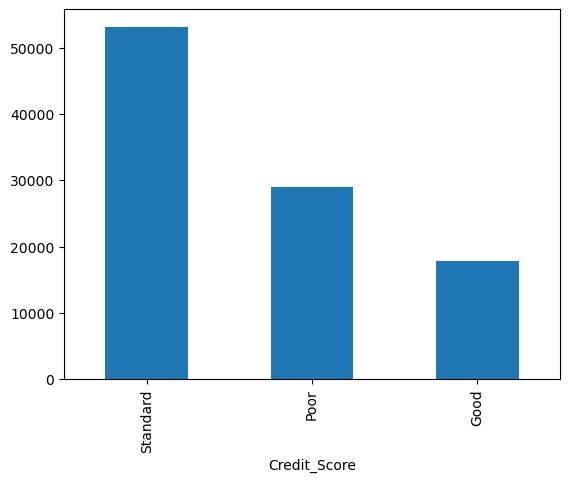

In [148]:
bank_df_cleaned['Credit_Score'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Count')

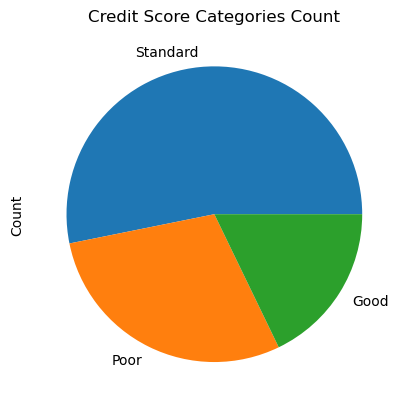

In [149]:
bank_df_cleaned['Credit_Score'].value_counts().plot(kind='pie')
plt.title('Credit Score Categories Count')
plt.xticks(rotation=-1)
plt.ylabel('Count')

Text(0.5, 1.0, 'Histogram of Customer Age')

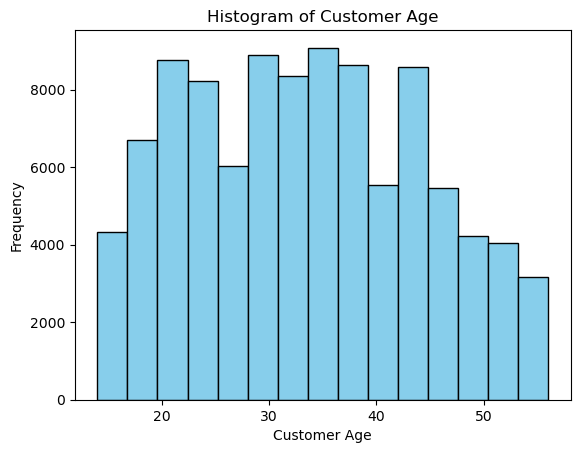

In [150]:
plt.hist(bank_df_cleaned['Age'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Histogram of Customer Age')

Text(0.5, 0, 'Count')

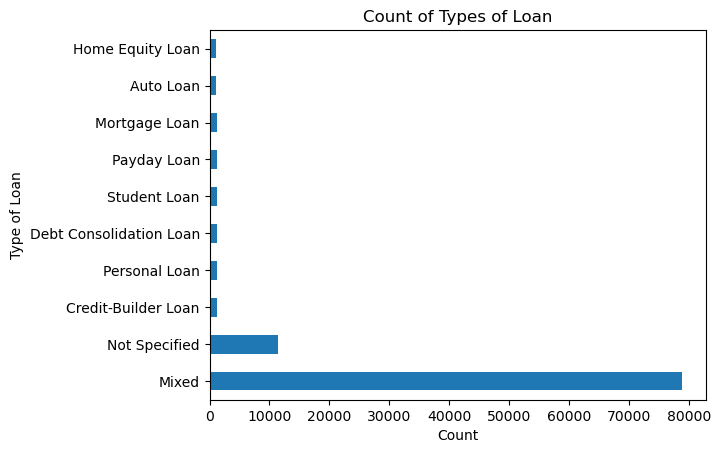

In [151]:
bank_df_cleaned['Type_of_Loan_fixed'].value_counts().plot(kind='barh')
plt.title('Count of Types of Loan')
plt.ylabel('Type of Loan')
plt.xlabel('Count')

Text(0.5, 1.0, 'Rate Distribution per Loans')

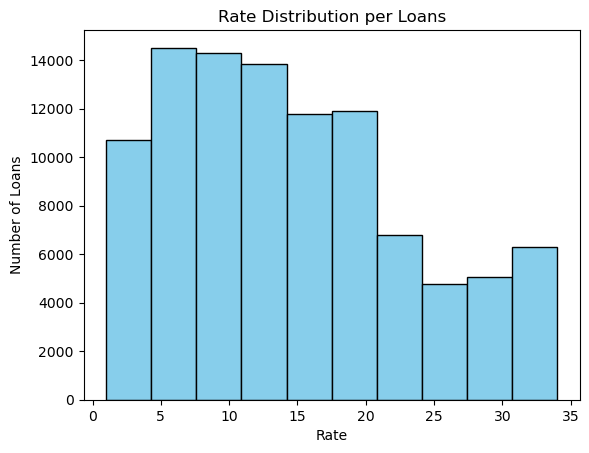

In [152]:
plt.hist(bank_df_cleaned['Interest_Rate'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rate')
plt.ylabel('Number of Loans')
plt.title('Rate Distribution per Loans')

In [153]:
# Credit_Mix
bank_df_cleaned['Credit_Mix'].replace('_','Standard')

0        Standard
1            Good
2            Good
3            Good
4            Good
           ...   
99995    Standard
99996    Standard
99997        Good
99998        Good
99999        Good
Name: Credit_Mix, Length: 99992, dtype: object

Text(0.5, 1.0, 'Credit Mix')

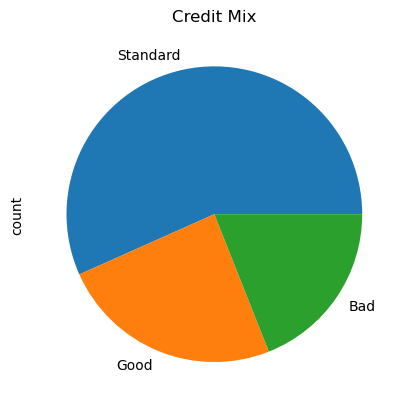

In [154]:
bank_df_cleaned['Credit_Mix'].value_counts().plot(kind='pie')
plt.title('Credit Mix')

Text(0.5, 1.0, 'Utilization Ratio of Credit Cards')

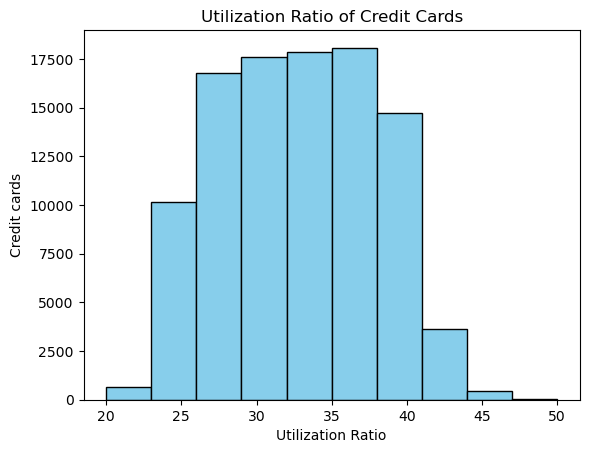

In [155]:
plt.hist(bank_df_cleaned['Credit_Utilization_Ratio'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Utilization Ratio')
plt.ylabel('Credit cards')
plt.title('Utilization Ratio of Credit Cards')

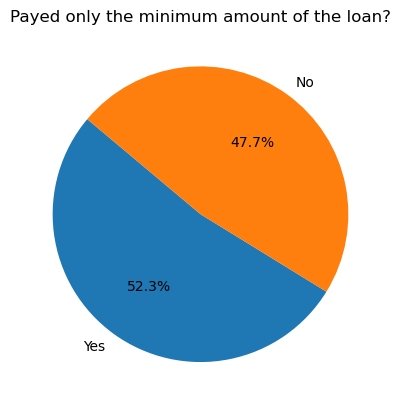

In [156]:
x = bank_df_cleaned['Payment_of_Min_Amount'].value_counts()

plt.pie(x.values, labels = x.index, autopct = '%1.1f%%', startangle = 140)
plt.title('Payed only the minimum amount of the loan?')
plt.show()

Text(0.5, 0, 'Customers')

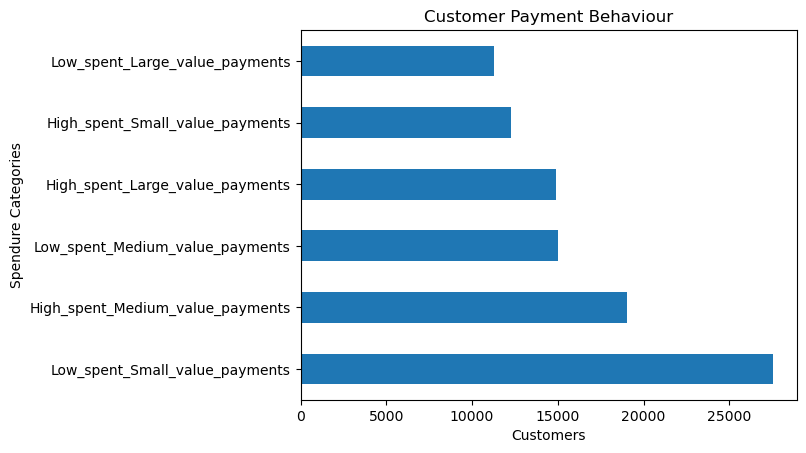

In [157]:
bank_df_cleaned['Payment_Behaviour'].value_counts().plot(kind='barh')
plt.title('Customer Payment Behaviour')
plt.ylabel('Spendure Categories')
plt.xlabel('Customers')

Text(0.5, 1.0, 'Credit History')

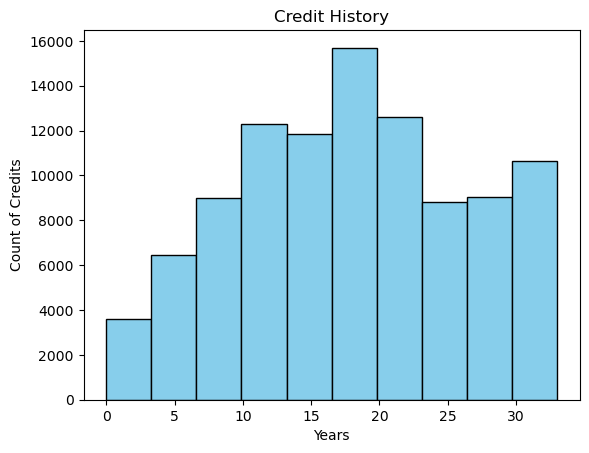

In [158]:
plt.hist(bank_df_cleaned['Years'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Years')
plt.ylabel('Count of Credits')
plt.title('Credit History')

Text(0.5, 1.0, 'Scatter Plot of Annual Income vs Monthly Inhand Salary')

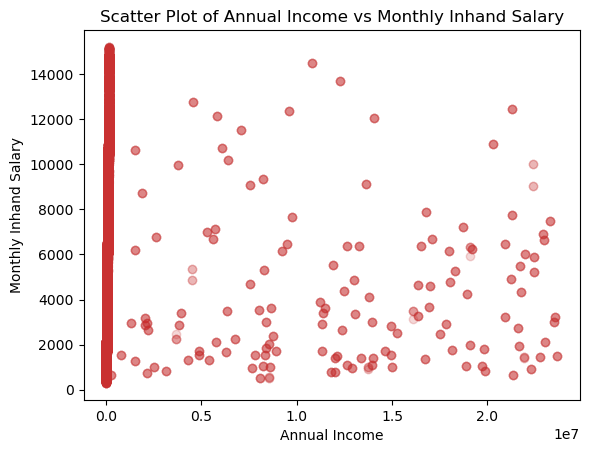

In [159]:
plt.scatter(bank_df_cleaned['Annual_Income'], bank_df_cleaned['Monthly_Inhand_Salary'], color='#C93131', alpha=.1)
plt.xlabel('Annual Income')
plt.ylabel('Monthly Inhand Salary')
plt.title('Scatter Plot of Annual Income vs Monthly Inhand Salary')

Text(0.5, 1.0, 'Scatter Plot of Bank Accounts vs Credit Cards')

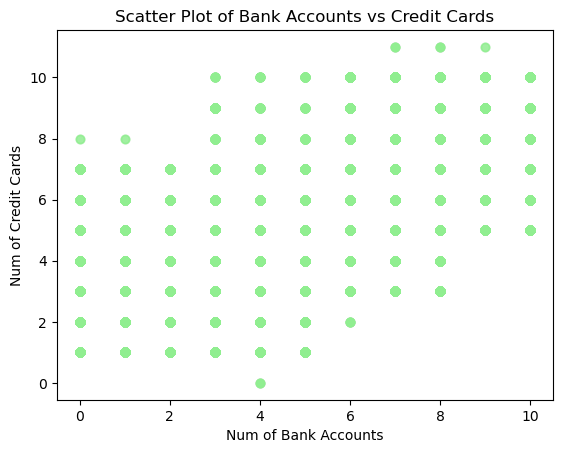

In [160]:
plt.scatter(bank_df_cleaned['Num_Bank_Accounts'], bank_df_cleaned['Num_Credit_Card'], color='lightgreen', alpha=.2)
plt.xlabel('Num of Bank Accounts')
plt.ylabel('Num of Credit Cards')
plt.title('Scatter Plot of Bank Accounts vs Credit Cards')

In [161]:
# Types_of_Loan

def types_loan(row):
    types_loan_categories = ["Home Equity Loan", "Auto Loan", "Mortgage Loan", "Payday Loan", "Student Loan", "Debt Consolidation Loan", "Personal Loan", "Credit-Builder Loan"]

    pattern = r'\d'
    if re.search(pattern, row):
        return "Not Specified"

    elif row in types_loan_categories:
        return row
    else:
        return "Mixed"
    
bank_df_cleaned["Type_of_Loan_fixed"]=bank_df_cleaned["Type_of_Loan"].apply(types_loan)


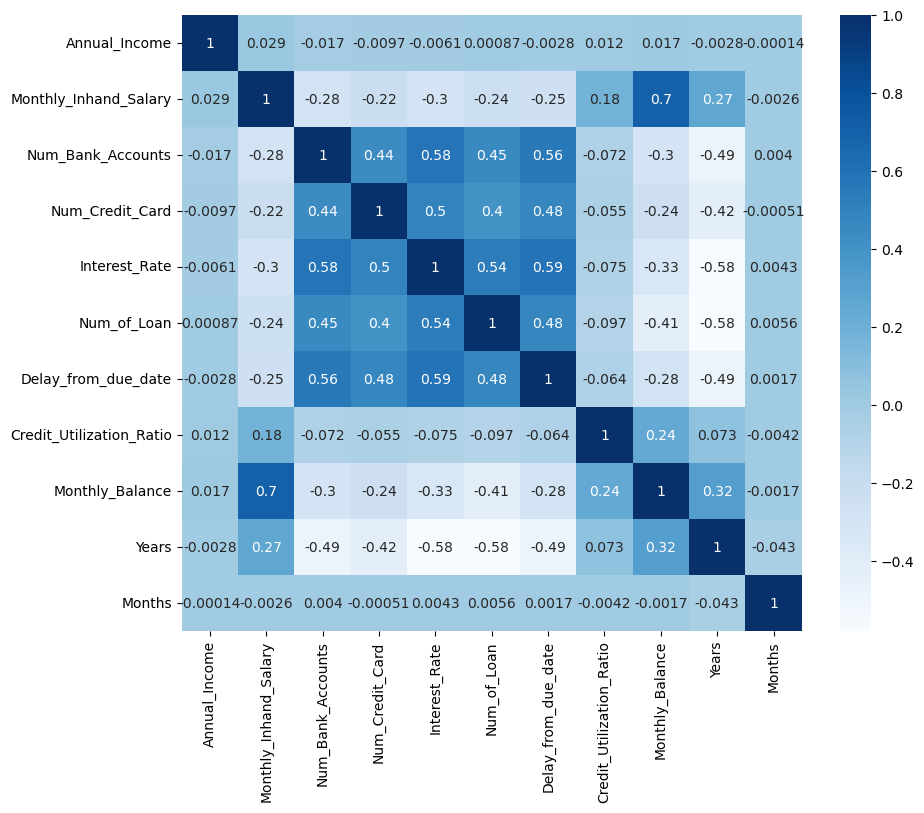

In [162]:
#Pearson Correlation
import seaborn as sns

X=bank_df_cleaned.select_dtypes(include=['number'])
X = X.drop(columns = ['Age', 'Month'])
y = ['Safe', 'Unsafe']

plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Blues)
plt.show()

In [163]:
bank_df_cleaned.to_csv('bank_df_cleaned.csv')
bank_df_cleaned.info()